In [1]:
import pandas as pd
import os
import numpy as np
import string
import matplotlib.pyplot as plt

In [2]:
#https://github.com/huggingface/notebooks/blob/main/examples/text_classification-tf.ipynb

In [3]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import datasets
from datasets import Dataset, concatenate_datasets, DatasetDict
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

import seaborn as sns

c:\Users\srandrad\Anaconda3\envs\MIKA\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys, os
sys.path.append(os.path.join(".."))
from mika.utils import Data
from mika.kd.NER import plot_eval_results
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

c:\Users\srandrad\Anaconda3\envs\MIKA\lib\site-packages\bertopic\_utils.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix
c:\Users\srandrad\smart_nlp\dev\..\mika\kd\NER.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn")


In [8]:
# filename = r"C:\Users\srandrad\smart_nlp\models\SafeAeroBERT\checkpoint-1000\trainer_state.json" # os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir, os.pardir)),"models", "FMEA-ner-model", "checkpoint-"+str(num_steps), "trainer_state.json")
# plot_eval_results(filename, save=True, savepath='', metrics=False)

## Load in Data

In [5]:
ASRS_file = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),'data/ASRS/ASRS_1988_2022.csv')
ASRS_id_col = 'ACN'
ASRS_text_cols = ['Report 1', 'Report 1.1', 'Report 2',	'Report 2.1', 'Report 1.2']
ASRS = Data()
ASRS.load(ASRS_file, id_col=ASRS_id_col, text_columns=ASRS_text_cols)
ASRS.prepare_data(combine_columns=ASRS_text_cols, remove_incomplete_rows=False)
ASRS_df = ASRS.data_df

..\mika\utils\Data.py:126: DtypeWarning: Columns (1,2,6,7,8,9,10,16,20,21,36,37,38,41,42,59,60,64,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,88,89,90,101,111,112,124) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data_df = pd.read_csv(open(filename,encoding='utf8',errors='ignore'), **kwargs)
Combining Columns…: 100%|███████████████████████████████████████████████████| 262935/262935 [00:05<00:00, 51955.95it/s]

data preparation:  0.08 minutes 




..\mika\utils\Data.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data_df["Combined Text"] = combined_text


In [6]:
ASRS_df

,ACN,Time,Time.1,Place,Place.1,Place.2,Place.3,Place.4,Place.5,Place.6,...,Events.4,Events.5,Assessments,Assessments.1,Report 1,Report 1.1,Report 2,Report 2.1,Report 1.2,Combined Text
0,79866,198801,1801-2400,CVG,OH,60,35,,31000,,...,,Air Traffic Control Issued New Clearance,,Human Factors,WE WERE IN OUR CLB FROM CMH TO DFW; WITH A CLR...,,,,AFTER LEAVING FL320 MLG INSTRUCTED TO DES TO F...,WE WERE IN OUR CLB FROM CMH TO DFW; WITH A CLR...
1,79912,198801,1201-1800,SEA; BFI,WA,,6,,900,,...,,Flight Crew Exited Penetrated Airspace,,Human Factors,THIS WAS MY FIRST DEP FROM BFI ON 31L. MY TURN...,,,,SMA PENETRATED TCA ON CLIMB OUT.,THIS WAS MY FIRST DEP FROM BFI ON 31L. MY TURN...
2,79965,198801,1201-1800,DEN,CO,,20,,7500,,...,,General None Reported / Taken,,Human Factors,A VFR FLT; BEING CONDUCTED UNDER FAR PART 91; ...,,,,SMT PLT DESCENDED TO ARPT UNDERLYING TCA; ACCU...,A VFR FLT; BEING CONDUCTED UNDER FAR PART 91; ...
3,79997,198801,1201-1800,LUK,OH,,5,0,,,...,,General None Reported / Taken,,Human Factors,SITUATION BEGAN ON A ROUTINE VFR PLEASURE FLT ...,,,,ATCT LCL CTLR MIXES UP CALL SIGNS.,SITUATION BEGAN ON A ROUTINE VFR PLEASURE FLT ...
4,79998,198801,1201-1800,PUT; BOS,MA,,20,,28000,,...,,Air Traffic Control Issued New Clearance; Flig...,,Human Factors,CLRD DIRECT PVT VOR AFTER TKOF BOS. USING R NA...,,,,FMS STEERED ACFT SOME 20-25 MI OFF COURSE WITH...,CLRD DIRECT PVT VOR AFTER TKOF BOS. USING R NA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262930,1917014,202207,0601-1200,ZLC.ARTCC,UT,,,,11500.0,,...,In-flight,General None Reported / Taken,Chart Or Publication; Environment - Non Weathe...,Chart Or Publication,I cleared Aircraft X for an ILS Approach at WY...,,,,ZLC Center Controller reported an aircraft des...,I cleared Aircraft X for an ILS Approach at WY...
262931,1917514,202207,0601-1200,ZZZ.Tower,US,,0.0,150.0,,,...,In-flight,Air Traffic Control Provided Assistance; Fligh...,Aircraft,Aircraft,During a normal take off roll after liftoff at...,,,,CE-441 pilot reported during initial climbout ...,During a normal take off roll after liftoff at...
262932,1917537,202207,,TSP.Airport,CA,,,,,,...,,General None Reported / Taken,Airport; Airspace Structure; Procedure; Human ...,Airspace Structure,Our concern here in the Tehachapi Valley are t...,,,,Local pilot at TSP reported the County designa...,Our concern here in the Tehachapi Valley are t...
262933,1917705,202207,,ZJX.ARTCC,FL,,,,29000.0,,...,,Air Traffic Control Issued New Clearance; Air ...,Human Factors; Chart Or Publication; Airspace ...,Chart Or Publication,Summer flying dodging T storms on descent into...,,,,An air carrier pilot descending into MCO repor...,Summer flying dodging T storms on descent into...


In [7]:
contributing_factors = [f for factors in ASRS_df['Assessments'].tolist() if type(factors) is str for f in factors.split("; ") ]
print(np.unique(contributing_factors, return_counts=True))
factor, counts = np.unique(contributing_factors, return_counts=True)

(array(['', 'ATC Equipment / Nav Facility / Buildings', 'Aircraft',
       'Airport', 'Airspace Structure', 'Chart Or Publication',
       'Company Policy', 'Contributing Factors / Situations',
       'Environment - Non Weather Related', 'Equipment / Tooling',
       'Human Factors', 'Incorrect / Not Installed / Unavailable Part',
       'Logbook Entry', 'MEL', 'Manuals', 'Procedure',
       'Software and Automation', 'Staffing', 'Weather'], dtype='<U44'), array([ 85916,   7346,  68440,  18530,  14277,  15141,  24635,     76,
        18443,   1659, 118600,   2697,   4597,   1165,   4594,  38502,
          334,   1677,  18305], dtype=int64))


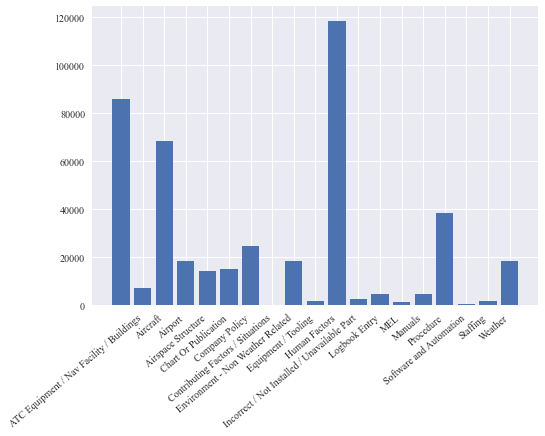

In [8]:
fig, ax = plt.subplots()
plt.bar(x=[i for i in range(len(counts))], height=counts, tick_label=factor)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [9]:
doc_cats = ['Human Factors', 'Weather', 'Software and Automation', 'Procedure', 'Airport', 'Airspace Structure', 'Aircraft', 'Environment - Non Weather Related']
cat_indicators = {cat:[] for cat in doc_cats}
for i in range(len(ASRS_df)):
    for cat in cat_indicators:
        if cat in str(ASRS_df.at[i,'Assessments']):
            cat_indicators[cat].append(1)
        else:
            cat_indicators[cat].append(0)
X = ASRS_df["Combined Text"]
y = pd.DataFrame(cat_indicators)
print(len(X), len(y))

262935 262935


In [10]:
def split_data(X, y, category, train_size=0.6, test_size=0.2, val_size=0.2, random_state=0):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size+val_size, random_state=random_state, stratify=y[category])
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), random_state=random_state, stratify=y_train_val[category])
    return X_train, X_test, X_val, y_train, y_test, y_val

In [11]:
train_size = 8000
test_size = 1000
val_size = 1000

In [12]:
X_train = {cat:[] for cat in doc_cats}
X_test = {cat:[] for cat in doc_cats}
X_val = {cat:[] for cat in doc_cats}
y_train = {cat:[] for cat in doc_cats}
y_test = {cat:[] for cat in doc_cats}
y_val = {cat:[] for cat in doc_cats}
for cat in doc_cats:
    X_train_temp, X_test_temp, X_val_temp, y_train_temp, y_test_temp, y_val_temp = split_data(X, y, cat, train_size, test_size, val_size)
    X_train[cat] = X_train_temp
    X_test[cat] = X_test_temp
    X_val[cat] = X_val_temp
    y_train[cat] = y_train_temp
    y_test[cat] = y_test_temp
    y_val[cat] = y_val_temp
    

In [13]:
iterables = [["Train", "Validation", "Test"], ["0", "1", "total"]]

ind = pd.MultiIndex.from_product(iterables)

pd.DataFrame([[len(y_train[cat].loc[y_train[cat][cat]==0]) for cat in doc_cats],
              [len(y_train[cat].loc[y_train[cat][cat]==1]) for cat in doc_cats],
              [len(X_train[cat]) for cat in doc_cats],
              [len(y_val[cat].loc[y_val[cat][cat]==0]) for cat in doc_cats],
              [len(y_val[cat].loc[y_val[cat][cat]==1]) for cat in doc_cats],
              [len(X_val[cat]) for cat in doc_cats],
              [len(y_test[cat].loc[y_test[cat][cat]==0]) for cat in doc_cats],
              [len(y_test[cat].loc[y_test[cat][cat]==1]) for cat in doc_cats],
              [len(X_test[cat]) for cat in doc_cats]],
              index = ind, columns = doc_cats)

Human Factors  Weather  Software and Automation  Procedure  \
Train      0               4391     6965                     7990       6828   
           1               3609     1035                       10       1172   
           total           8000     8000                     8000       8000   
Validation 0                549      871                      999        854   
           1                451      129                        1        146   
           total           1000     1000                     1000       1000   
Test       0                549      871                      999        854   
           1                451      129                        1        146   
           total           1000     1000                     1000       1000   

                  Airport  Airspace Structure  Aircraft  \
Train      0         7436                7565      5917   
           1          564                 435      2083   
           total     8000                8000      8000   
Validation 0          930                 946       740   
           1           70                  54       260   
           total     1000                1000      1000   
Test       0          930                 946       740   
           1           70                  54       260   
           total     1000                1000      1000   

                  Environment - Non Weather Related  
Train      0                                   7439  
           1                                    561  
           total                               8000  
Validation 0                                    930  
           1                                     70  
           total                               1000  
Test       0                                    930  
           1                                     70  
           total                               1000

## Load in SafeAeroBERT

In [14]:
model_checkpoint = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),"models", "SafeAeroBERT", "checkpoint-1000")
##"bert-base-uncased"#"distilbert-base-uncased"
#"allenai/scibert_scivocab_uncased" 
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")#model_checkpoint)

Some weights of the model checkpoint at C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized 

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [15]:
contributing_factor = 'Procedure'#'Human Factors'

In [16]:
x_train = X_train[contributing_factor]
y_train = y_train[contributing_factor][contributing_factor]
x_valid = X_val[contributing_factor]
y_valid = y_val[contributing_factor][contributing_factor]
x_test = X_test[contributing_factor]
y_test = y_test[contributing_factor][contributing_factor]

In [17]:
def tokenize(text_df, tokenizer):
    tokenized_inputs = tokenizer(text_df["Combined Text"],truncation=True)
    return tokenized_inputs

In [18]:
train = Dataset.from_pandas(x_train.to_frame()).map(lambda example: {'idx': example['__index_level_0__']}, remove_columns=['__index_level_0__'])
valid = Dataset.from_pandas(x_valid.to_frame()).map(lambda example: {'idx': example['__index_level_0__']}, remove_columns=['__index_level_0__'])
test = Dataset.from_pandas(x_test.to_frame()).map(lambda example: {'idx': example['__index_level_0__']}, remove_columns=['__index_level_0__'])
train_labels = Dataset.from_pandas(y_train.to_frame()).map(lambda example: {'label': example[contributing_factor]}, remove_columns=['__index_level_0__', contributing_factor])
valid_labels = Dataset.from_pandas(y_valid.to_frame()).map(lambda example: {'label': example[contributing_factor]}, remove_columns=['__index_level_0__', contributing_factor])
test_labels = Dataset.from_pandas(y_test.to_frame()).map(lambda example: {'label': example[contributing_factor]}, remove_columns=['__index_level_0__', contributing_factor])
test_data = concatenate_datasets([test, test_labels], axis=1)
train_data = concatenate_datasets([train, train_labels], axis=1)
valid_data = concatenate_datasets([valid, valid_labels], axis=1)

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

In [19]:
train_data

Dataset({
    features: ['Combined Text', 'idx', 'label'],
    num_rows: 8000
})

In [20]:
dataset = DatasetDict({'train': train_data,
                      'valid': valid_data,
                      'test': test_data})

encoded_dataset = dataset.map(tokenize, fn_kwargs={'tokenizer':tokenizer}, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
encoded_dataset["train"].features["label"]

Value(dtype='int64', id=None)

In [22]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 2
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    #save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    #load_best_model_at_end=True,
    push_to_hub=False,
)

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [23]:
def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    predictions = np.argmax(predictions, axis=1)
    precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"precision": precision, #all_metrics["overall_precision"],
            "recall": recall, #all_metrics["overall_recall"],
            "f1": fscore, #all_metrics["overall_f1"],
            "accuracy": accuracy} #all_metrics["overall_accuracy"]}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\srandrad\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
C:\Users\srandrad\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [25]:
max([len(encoded_dataset["train"][i]['input_ids']) for i in range(8000)])

512

In [26]:
encoded_dataset["train"][0].keys()

dict_keys(['Combined Text', 'idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
history = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Combined Text, idx. If Combined Text, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8000
  Num Epochs = 5
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 20000


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.526300,0.499020,0.876778,0.856000,0.791544,0.856000
2,0.494200,0.579709,0.857514,0.866000,0.819748,0.866000
3,0.479300,0.450920,0.882462,0.890000,0.885054,0.890000
4,0.338900,0.600862,0.871808,0.885000,0.872910,0.885000
5,0.429600,0.552927,0.879020,0.890000,0.880684,0.890000


Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-500
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-500\config.json
Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-500\pytorch_model.bin
tokenizer config file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-500\tokenizer_config.json
Special tokens file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-500\special_tokens_map.json
Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-1000
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-1000\config.json
Model weights saved in C:\Users\sr

Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6000\config.json
Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6000\pytorch_model.bin
tokenizer config file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6000\tokenizer_config.json
Special tokens file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6000\special_tokens_map.json
Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6500
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6500\config.json
Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-6500\pytorch_model.bin
tokenizer confi

Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-11500\pytorch_model.bin
tokenizer config file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-11500\tokenizer_config.json
Special tokens file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-11500\special_tokens_map.json
Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-12000
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-12000\config.json
Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-12000\pytorch_model.bin
tokenizer config file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-12000\tokenizer_co

Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17000
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17000\config.json
Model weights saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17000\pytorch_model.bin
tokenizer config file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17000\tokenizer_config.json
Special tokens file saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17000\special_tokens_map.json
Saving model checkpoint to C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17500
Configuration saved in C:\Users\srandrad\Documents\smart_nlp\models\SafeAeroBERT\checkpoint-1000-finetuned\checkpoint-17500\config.json
Model weights saved in

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [28]:
preds, label_ids, pred_metric = trainer.predict(encoded_dataset["valid"])
val_pred = np.argmax(preds, axis=1)
preds, label_ids, pred_metric = trainer.predict(encoded_dataset["train"])
train_pred = np.argmax(preds, axis=1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Combined Text, idx. If Combined Text, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 2


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Combined Text, idx. If Combined Text, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 8000
  Batch size = 2


In [29]:
print(classification_report(encoded_dataset["train"]['label'], train_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6828
           1       0.85      0.64      0.73      1172

    accuracy                           0.93      8000
   macro avg       0.90      0.81      0.84      8000
weighted avg       0.93      0.93      0.93      8000



In [30]:
print(classification_report(encoded_dataset["valid"]['label'], val_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       854
           1       0.68      0.46      0.55       146

    accuracy                           0.89      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.88      0.89      0.88      1000



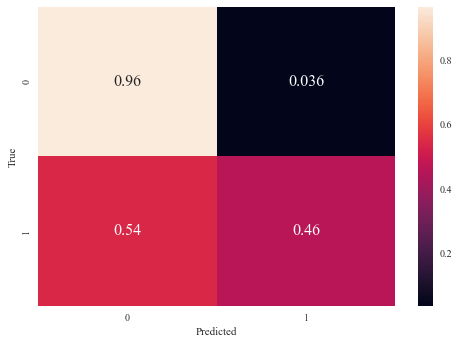

In [31]:
cm = confusion_matrix(encoded_dataset["valid"]['label'], val_pred, normalize='true')  
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Combined Text, idx. If Combined Text, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 2


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       854
           1       0.60      0.44      0.51       146

    accuracy                           0.88      1000
   macro avg       0.76      0.69      0.72      1000
weighted avg       0.86      0.88      0.87      1000



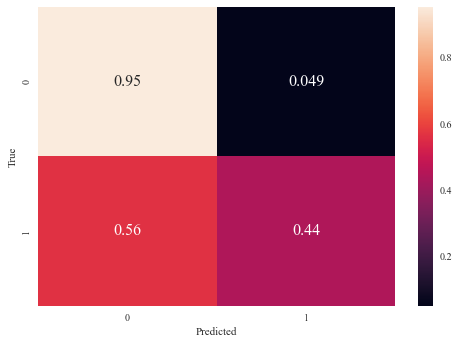

In [32]:
preds, label_ids, pred_metric = trainer.predict(encoded_dataset["test"])
test_pred = np.argmax(preds, axis=1)
print(classification_report(encoded_dataset["test"]['label'], test_pred))
cm = confusion_matrix(encoded_dataset["test"]['label'], test_pred, normalize='true')  
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()